Reference:
* [Notebook](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/ungradedLab/Wlfvj/implement-a-fully-convolutional-neural-network) in course "Advanced Computer Vision with TensorFlow" by DeepLearning.AI

* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) TF official tutorial.

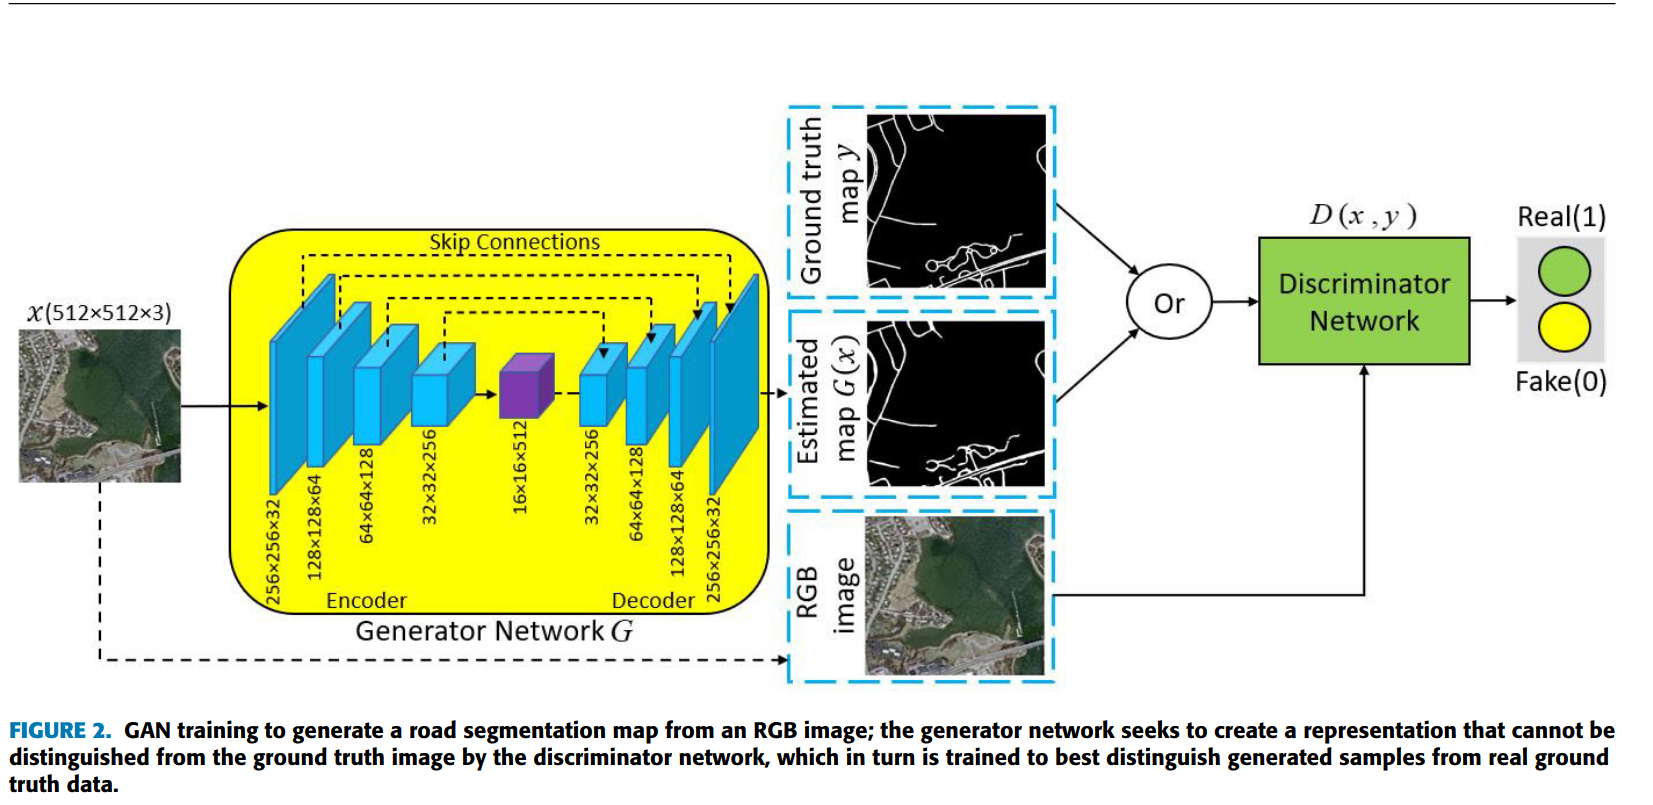

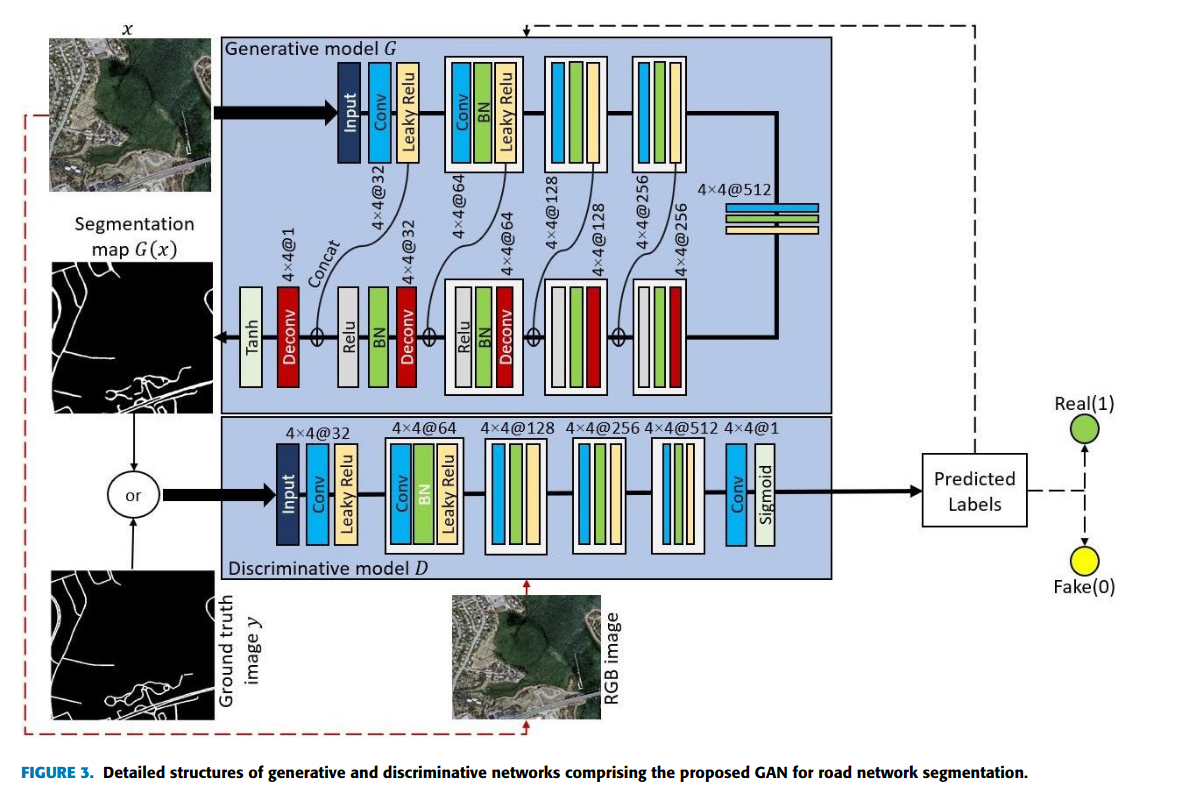

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Generator

In [2]:
BATCH_SIZE = 1

IMG_SIZE = (512, 512)

NUM_CLASSES = 5

## Encoder Utilities

In [3]:
def encoder_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True):
    """
    Creates encoder block which consists of:
    
    Conv2d → BatchNormalization(except first block) → LeakyReLu
    
    Args:
        input_tensor (tensor) -- the input te nsor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution
        batch_normalization -- if BatchNormalization layer should be
                               included
    Returns:
        x -- the output features of the convolution block 

    
    """
    
    x = input_tensor
    
    x = layers.Conv2D(filters=n_filters, 
                      kernel_size=kernel_size,
                      strides=(2,2),
                      activation='relu', 
                      padding='same',
                      name=block_name + '_Conv2D')(x)

    if batch_normalization:

        x = layers.BatchNormalization(name=block_name + '_BN')(x)

    x = layers.LeakyReLU(name=block_name + '_LeakyRelu')(x)
    
    return x

## Encoder

In [4]:
def encoder(inputs):
    '''
    This function defines the encoder or downsampling path.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
        (e1, e2, e3, e4) -- tuple of features for concating layers
            in decoder
        e5 -- final output to pass to decoder

    '''
    e1 = encoder_block(inputs, n_filters=32,
                       block_name='encoder_block_1', 
                       batch_normalization=False)
    
    e2 = encoder_block(e1, n_filters=64, block_name='encoder_block_2')
    
    e3 = encoder_block(e2, n_filters=128, block_name='encoder_block_3')
    
    e4 = encoder_block(e3, n_filters=256, block_name='encoder_block_4')
    
    e5 = encoder_block(e4, n_filters=512, block_name='encoder_block_5')
    
    return (e1, e2, e3, e4, e5)


## Decoder Utilities

In [5]:
def decoder_block(input_tensor, n_filters, block_name,
                 kernel_size=4):
    """
    Creates encoder block which consists of:
    
    Conv2d → BatchNormalization(except first block) → LeakyReLu
    
    Args:
        input_tensor (tensor) -- the input te nsor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution
        batch_normalization -- if BatchNormalization layer should be
                               included
    Returns:
        x -- the output features of the convolution block 

    
    """
    
    x = input_tensor
    
    x = layers.Conv2DTranspose(filters=n_filters, 
                              kernel_size=kernel_size,
                              strides=(2,2),
                              activation='relu', 
                              padding='same',
                              name=block_name + '_Conv2DTranspose')(x)
        
    x = layers.BatchNormalization(name=block_name + '_BN')(x)

    x = layers.ReLU(name=block_name + '_ReLu')(x)
     
    return x

## Decoder

In [6]:
def decoder(convs):
    '''
    This function defines the decoder.

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks

    Returns:
    
    outputs: mask with each pixel having assigned s
    '''
    
    e1, e2, e3, e4, e5 = convs
    
    
    d1 = decoder_block(e5, n_filters=256,
                       block_name='decoder_block_1')
    
    c1 = layers.concatenate([d1, e4])
    
    d2 = decoder_block(c1, n_filters=128, block_name='decoder_block_2')
    
    c2 = layers.concatenate([d2, e3])
    
    d3 = decoder_block(c2, n_filters=64, block_name='decoder_block_3')
    
    c3 = layers.concatenate([d3, e2])
    
    d4 = decoder_block(c3, n_filters=32, block_name='decoder_block_4')
    
    c4 = layers.concatenate([d4, e1])
    
    d5 = layers.Conv2DTranspose(filters=NUM_CLASSES,
                                kernel_size=4,
                                strides=(2,2), 
                                padding='same',
                                name='decoder_block_5_conv2DTranspose')(c4)
    
    outputs = layers.Activation(activation=tf.nn.sigmoid,
                                name='decoder_output')(d5)
    
    
    return outputs

## Define and instantiate the model

In [7]:
def make_generator():
    '''
    Defines MUNet by connecting encoder and decoder.
    
    '''
    
    # specify input shape; image is in RGB
    inputs = layers.Input(shape=[512,512,3])
    
    # feed the inputs to the encoder
    encoder_output = encoder(inputs)
    
    # feed the encoder output and encoder block outputs to the decoder
    # specify the number of classes via the 'output_channels' argument
    outputs = decoder(encoder_output)
    
    # create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs,
                          name='Generator')
    
    return model


# instantiate the model
generator= make_generator()

# see the resulting model architecture
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
encoder_block_1_Conv2D (Conv2D) (None, 256, 256, 32) 1568        input_1[0][0]                    
__________________________________________________________________________________________________
encoder_block_1_LeakyRelu (Leak (None, 256, 256, 32) 0           encoder_block_1_Conv2D[0][0]     
__________________________________________________________________________________________________
encoder_block_2_Conv2D (Conv2D) (None, 128, 128, 64) 32832       encoder_block_1_LeakyRelu[0][0]  
__________________________________________________________________________________________

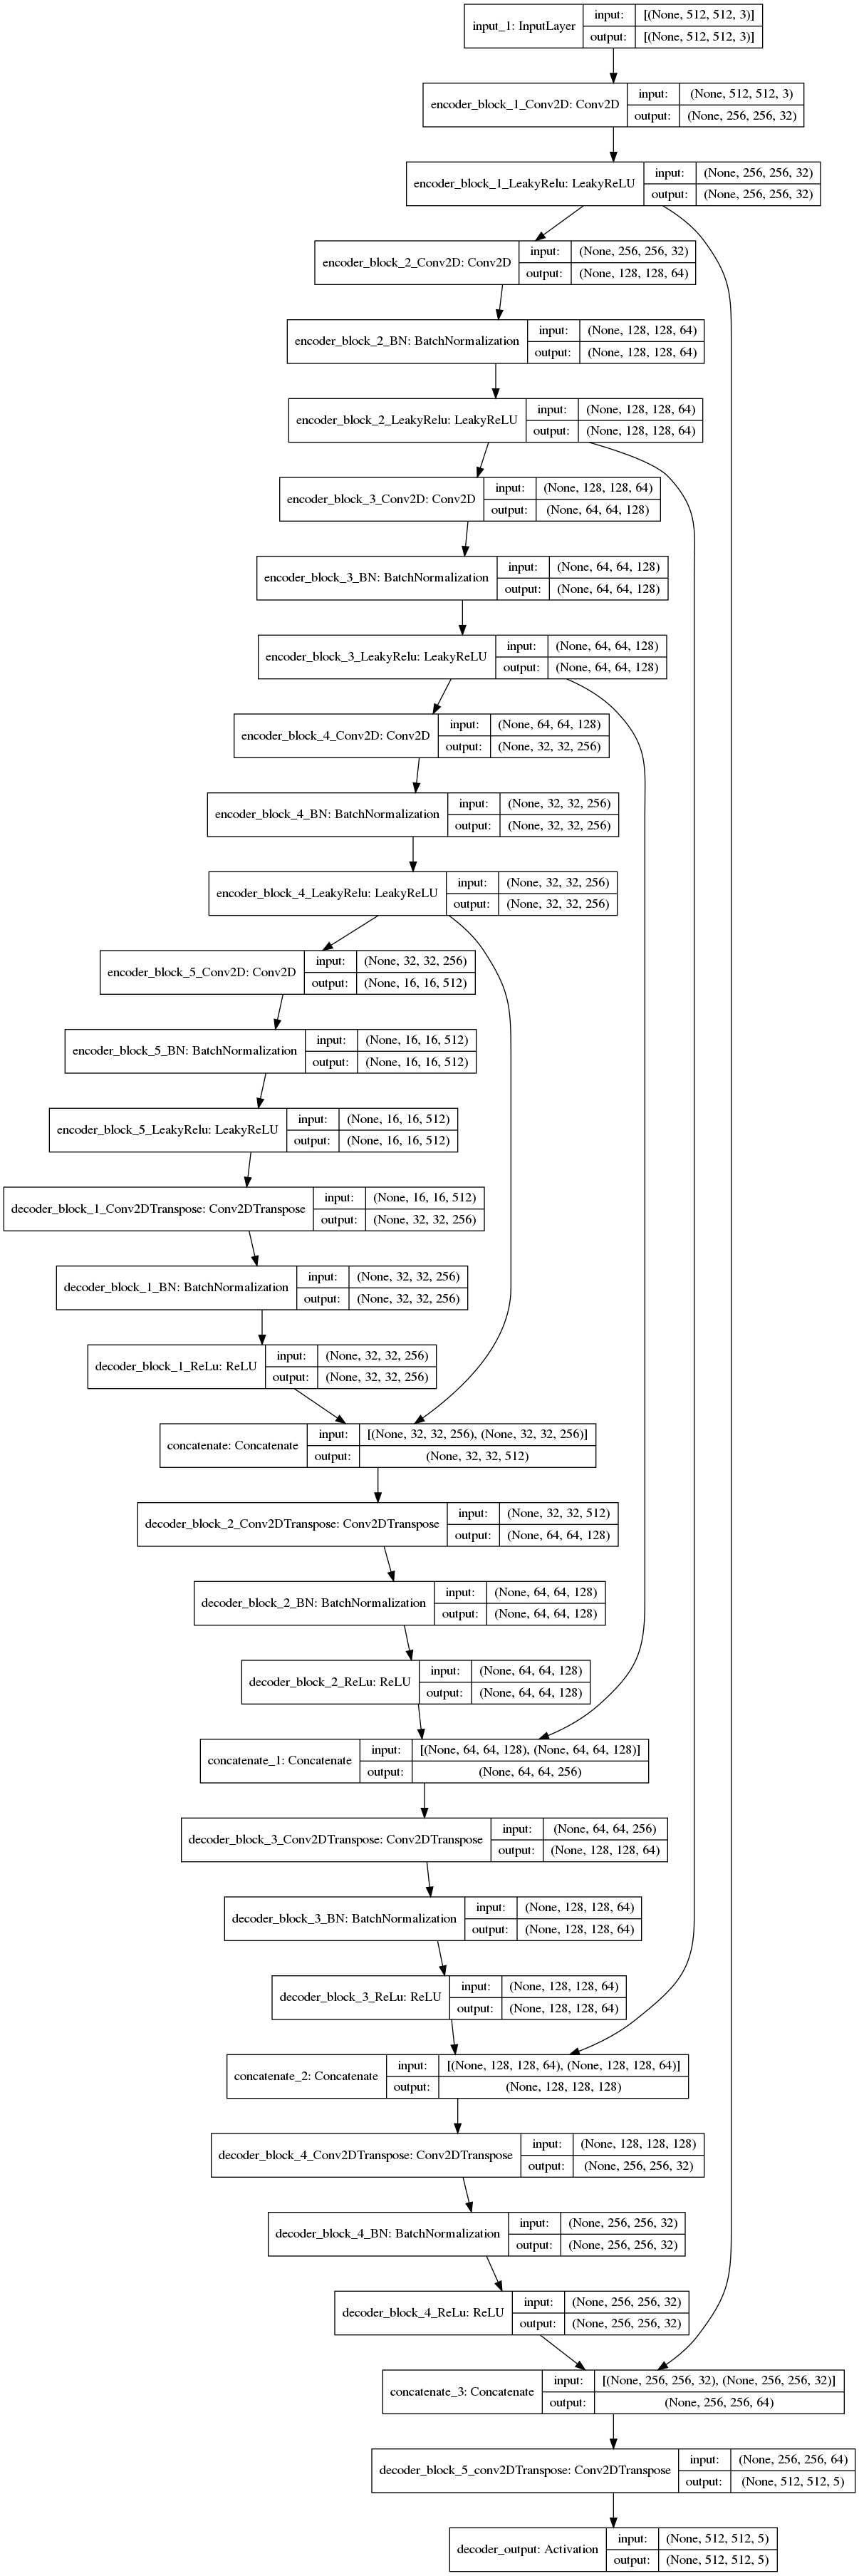

In [8]:
tf.keras.utils.plot_model(generator, show_shapes=True, to_file='GAN_MUNET.png')

# Discriminator

## Utilities

In [9]:
def discriminator_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True):
    """
    Creates encoder block which consists of:
    
    Conv2d → BatchNormalization(except first block) → LeakyReLu
    
    Args:
        input_tensor (tensor) -- the input tensor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution
        batch_normalization -- if BatchNormalization layer should be
                               included
    Returns:
        x -- the output features of the discriminator block 
    """
    
    x = input_tensor
    
    x = layers.Conv2D(filters=n_filters, 
                      kernel_size=kernel_size,
                      strides=(2, 2),
                      activation='relu', 
                      padding='same',
                      name=block_name + '_Conv2D')(x)

    if batch_normalization:

        x = layers.BatchNormalization(name=block_name + '_BN')(x)

    x = layers.LeakyReLU(name=block_name + '_LeakyRelu')(x)
    
    return x

## Model

discriminator_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True)

In [10]:
def make_discriminator(input_shape = [512, 512, 5]):
    
    '''
    This function defines the discriminator.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
    
    '''
    inputs = layers.Input(shape=input_shape)
    
    d1 = discriminator_block(inputs, 32, 'discriminator_block_1',
                            batch_normalization=False)
    
    d2 = discriminator_block(d1, 64, 'discriminator_block_2')
    
    d3 = discriminator_block(d2, 128, 'discriminator_block_3')
    
    d4 = discriminator_block(d3, 256, 'discriminator_block_4')
    
    d5 = discriminator_block(d4, 512, 'discriminator_block_5')
    
    d6 = layers.Conv2D(filters=1, 
                      kernel_size=4,
                      strides=(2, 2),
                      activation='relu',
                      padding='same',
                      name='discriminator_block_5_Conv2d')(d5)
    
#     outputs = layers.Activation(activation='sigmoid',
#                               name='discriminator_output')(d6)
    
    d8 = layers.Flatten()(d6)
    
    outputs = layers.Dense(1, activation='sigmoid')(d8)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs,
                           name='Discriminator')
    
    return model

In [11]:

discriminator = make_discriminator()

discriminator.summary()
    

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 5)]     0         
_________________________________________________________________
discriminator_block_1_Conv2D (None, 256, 256, 32)      2592      
_________________________________________________________________
discriminator_block_1_LeakyR (None, 256, 256, 32)      0         
_________________________________________________________________
discriminator_block_2_Conv2D (None, 128, 128, 64)      32832     
_________________________________________________________________
discriminator_block_2_BN (Ba (None, 128, 128, 64)      256       
_________________________________________________________________
discriminator_block_2_LeakyR (None, 128, 128, 64)      0         
_________________________________________________________________
discriminator_block_3_Conv2D (None, 64, 64, 128)     

## Compile models

In [12]:
# generator.compile(optimizer=generator_optimizer,
#                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                  metrics=['accuracy'])

# Load data

In [13]:
abs_path = %pwd

In [14]:
slash_idx = [idx for idx,ch in enumerate(abs_path) if ch=='/']

abs_path = abs_path[:slash_idx[-2]]

abs_path

'/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset'

In [15]:
data_path = abs_path + '/data/processed'
data_path

'/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed'

In [16]:
def get_data_generator(path_to_data_split):
    
    seed = 909
    
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    
    image_generator = image_datagen.flow_from_directory(path_to_data_split+'/images',
                                                       class_mode=None,
                                                       batch_size=BATCH_SIZE,
                                                       seed=seed,
                                                       target_size=IMG_SIZE)

    mask_generator = mask_datagen.flow_from_directory(path_to_data_split+'/masks',
                                                     class_mode=None,
                                                     batch_size=BATCH_SIZE,
                                                     seed=seed,
                                                     target_size=IMG_SIZE)
        
    generator = zip(image_generator, mask_generator)

    
    return generator 

In [17]:
TRAIN_PATH = data_path + '/train'
VAL_PATH = data_path + '/val'
TEST_PATH = data_path + '/test'

In [18]:
TRAIN_PATH

'/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed/train'

In [19]:
train_generator =  get_data_generator(TRAIN_PATH)

val_generator = get_data_generator(VAL_PATH)

test_generator =  get_data_generator(TEST_PATH)

Found 7470 images belonging to 1 classes.
Found 7470 images belonging to 1 classes.
Found 1602 images belonging to 1 classes.
Found 1602 images belonging to 1 classes.
Found 1602 images belonging to 1 classes.
Found 1602 images belonging to 1 classes.


In [20]:
def mask_to_categorical(mask):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)
    mask = tf.cast(mask, tf.float32)
    return mask

In [21]:
import matplotlib.pyplot as plt
import matplotlib

In [22]:
def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

In [30]:
from matplotlib import colors

In [178]:
class_colors = ['black', 'red', 'green', 'blue', 'white']

EACH_CLASS_CMAP = matplotlib.colors.ListedColormap(class_colors)

bounds=[0, 1, 2, 3, 4]

CLASS_NORM = colors.BoundaryNorm(bounds, EACH_CLASS_CMAP.N)

In [179]:
img, mask = zip(next(test_generator))

sample_img = img[0]
sample_mask = mask[0]

prediction_mask = generator.predict(sample_img)

sample_mask = mask_to_categorical(sample_mask)

out = tf.argmax(sample_mask, axis=-1)

out_add_axis = out[..., tf.newaxis]

print(len(mask), sample_mask.shape, out.shape, out_add_axis.shape)

1 (1, 512, 512, 5) (1, 512, 512) (1, 512, 512, 1)


In [180]:
sample_img.shape

(1, 512, 512, 3)

In [181]:
prediction_mask.shape

(1, 512, 512, 5)

In [182]:
create_mask(prediction_mask).shape

TensorShape([512, 512, 1])

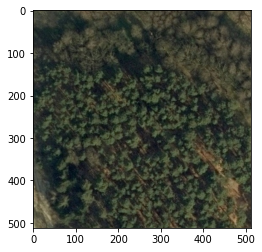

In [183]:
plt.imshow(sample_img[0])

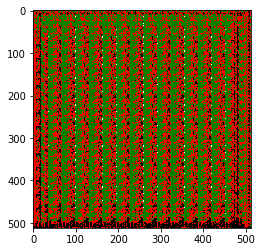

In [184]:
plt.imshow(create_mask(prediction_mask), cmap=EACH_CLASS_CMAP, norm=CLASS_NORM)

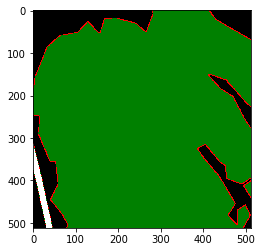

In [185]:
plt.imshow(out_add_axis[0], cmap=EACH_CLASS_CMAP, norm=CLASS_NORM)

In [186]:
def show_predictions(cmap_mask, norm):

    img, mask = zip(next(test_generator))

    sample_img = img[0][0]
    sample_mask = mask[0][0]
    
    fig = plt.figure()

    f,ax = plt.subplots(1, 3, figsize=(12,6))
    
    ax[0].imshow(sample_img)
    ax[0].set_title('Real image')
    ax[0].axis('off')

    ax[1].imshow(sample_mask[:, :, 0], cmap=cmap_mask, norm=norm)
    ax[1].set_title("Real mask")
    ax[1].axis('off')

    ax[2].imshow(create_mask(generator.predict(sample_img[tf.newaxis, ...])), cmap=cmap_mask, norm=norm)
    ax[2].set_title("Generated mask")
    ax[2].axis('off')

In [161]:
from matplotlib import colors

<Figure size 432x288 with 0 Axes>

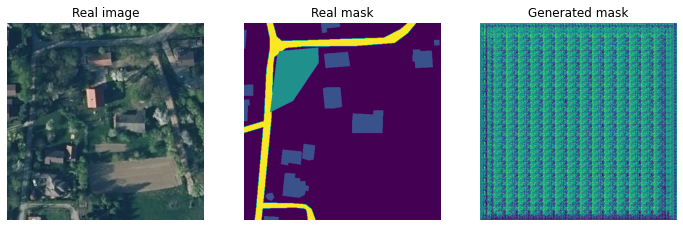

In [241]:
MASK_CMAP = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Accent").colors[:5])

show_predictions(None, None)

In [210]:
# generator returns zipped images and masks
img, mask = zip(next(test_generator))

img = img[0][0]
mask = mask[0][0]

sample_pred = generator.predict(img[tf.newaxis, ...])

In [164]:
sample_pred.shape

(1, 512, 512, 5)

In [165]:
sample_pred[0, 5, 25, :]

array([1.9639696e-04, 3.4425942e-05, 1.1040327e-03, 4.7909166e-06,
       2.0643316e-05], dtype=float32)

In [166]:
display_sample_pred = tf.argmax(sample_pred, axis=-1)

display_sample_pred = display_sample_pred[..., tf.newaxis]

display_sample_pred.shape

TensorShape([1, 512, 512, 1])

In [167]:
display_sample_pred[0, :6, 5]

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [2]])>

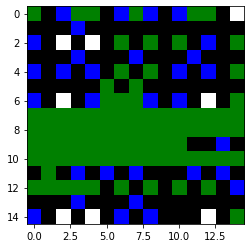

In [168]:
plt.imshow(display_sample_pred[0, :15, :15, :], cmap=EACH_CLASS_CMAP, norm=CLASS_NORM)

In [49]:
# generator returns zipped images and masks
batch_img, batch_mask = zip(next(test_generator))

batch_img = batch_img[0]

batch_mask = batch_mask[0]

sample_batch_pred = generator.predict(batch_img)

In [50]:
batch_img.shape

(1, 512, 512, 3)

In [51]:
batch_mask.shape

(1, 512, 512, 3)

In [52]:
sample_batch_pred = tf.argmax(sample_batch_pred, axis=-1)

sample_batch_pred = sample_batch_pred[..., tf.newaxis]

sample_batch_pred.shape

TensorShape([1, 512, 512, 1])

In [53]:
cat_mask = to_categorical(batch_mask[..., 0], NUM_CLASSES)

cat_mask.shape

(1, 512, 512, 5)

In [54]:
# pixel class in one-hot format
cat_mask[0, 12, 5, :]

array([0., 0., 1., 0., 0.], dtype=float32)

In [55]:
batch_img, batch_mask = zip(next(test_generator))

batch_mask = batch_mask[0]

tf.argmax(create_mask(batch_mask), axis=-1)[20:50, 20:50]

<tf.Tensor: shape=(30, 30), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

<tf.Tensor: shape=(40, 20), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

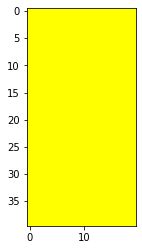

In [56]:
batch_img, batch_mask = zip(next(test_generator))

batch_img = batch_img[0]

batch_mask = batch_mask[0]

plt.imshow(batch_mask[0, :40, :20, 0], cmap=EACH_CLASS_CMAP, norm=CLASS_NORM)

batch_mask = mask_to_categorical(batch_mask)

create_mask(batch_mask)[:40, :20, 0]

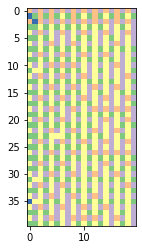

In [57]:
img_pred = generator(batch_img, training=False)

plt.imshow(create_mask(img_pred[:, :40, :20, :]), cmap=MASK_CMAP)

# Loss and optimizers

In [58]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                              beta_1=0.9,
                                              beta_2=0.999)

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                  beta_1=0.9,
                                                  beta_2=0.999)

In [59]:
# disc_cross_entropy = tf.keras.losses.BinaryCrossentropy()

# gen_cross_entropy =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# def discriminator_loss(real_output, fake_output):
#     real_loss = disc_cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = disc_cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return gen_cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator_loss = discriminator_loss

# generator_loss = generator_loss

In [60]:
y_true = [[0, 1.0, 0, 0, 0]]
y_pred = [[0, 1,0.0, 0.0, 1.0]]
# Using 'auto'/'sum_over_batch_size' reduction type.
scce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
scce(y_true, y_pred).numpy()

0.6931472

In [61]:
y_true = [[1.0]]
y_pred = [[0.0]]
# Using 'auto'/'sum_over_batch_size' reduction type.
scce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
scce(y_true, y_pred).numpy()

nan

In [62]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [63]:
# def _to_float(tensor):
#     return tf.cast(tensor, tf.float32)


# def wasserstein_generator_loss(
#     discriminator_gen_outputs,
#     weights=1.0,
#     scope=None,
#     loss_collection=tf.compat.v1.GraphKeys.LOSSES,
#     reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
#     add_summaries=False):
#     """Wasserstein generator loss for GANs.
#     See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
#     Args:
#     discriminator_gen_outputs: Discriminator output on generated data. Expected
#       to be in the range of (-inf, inf).
#     weights: Optional `Tensor` whose rank is either 0, or the same rank as
#       `discriminator_gen_outputs`, and must be broadcastable to
#       `discriminator_gen_outputs` (i.e., all dimensions must be either `1`, or
#       the same as the corresponding dimension).
#     scope: The scope for the operations performed in computing the loss.
#     loss_collection: collection to which this loss will be added.
#     reduction: A `tf.losses.Reduction` to apply to loss.
#     add_summaries: Whether or not to add detailed summaries for the loss.
#     Returns:
#     A loss Tensor. The shape depends on `reduction`.
#     """
#     with tf.compat.v1.name_scope(scope, 'generator_wasserstein_loss',
#                                (discriminator_gen_outputs, weights)) as scope:
        
#         discriminator_gen_outputs = _to_float(discriminator_gen_outputs)

#         loss = - discriminator_gen_outputs
#         loss = tf.compat.v1.losses.compute_weighted_loss(loss, weights, scope,
#                                                          loss_collection, reduction)

#         if add_summaries:
#             tf.compat.v1.summary.scalar('generator_wass_loss', loss)

#     return loss


# def wasserstein_discriminator_loss(
#     discriminator_real_outputs,
#     discriminator_gen_outputs,
#     real_weights=1.0,
#     generated_weights=1.0,
#     scope=None,
#     loss_collection=tf.compat.v1.GraphKeys.LOSSES,
#     reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
#     add_summaries=False):
    
#     """Wasserstein discriminator loss for GANs.
#     See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
    
#     Args:
    
#     discriminator_real_outputs: Discriminator output on real data.
    
#     discriminator_gen_outputs: Discriminator output on generated data. Expected
#       to be in the range of (-inf, inf).
    
#     real_weights: Optional `Tensor` whose rank is either 0, or the same rank as
#       `discriminator_real_outputs`, and must be broadcastable to
#       `discriminator_real_outputs` (i.e., all dimensions must be either `1`, or
#       the same as the corresponding dimension).
    
#     generated_weights: Same as `real_weights`, but for
#       `discriminator_gen_outputs`.
    
#     scope: The scope for the operations performed in computing the loss.
    
#     loss_collection: collection to which this loss will be added.
    
#     reduction: A `tf.losses.Reduction` to apply to loss.
    
#     add_summaries: Whether or not to add summaries for the loss.
    
#     Returns:
#     A loss Tensor. The shape depends on `reduction`.
#     """
    
#     with tf.compat.v1.name_scope(
#         scope, 'discriminator_wasserstein_loss',
#         (discriminator_real_outputs, discriminator_gen_outputs, real_weights,
#         generated_weights)) as scope:

#         discriminator_real_outputs = _to_float(discriminator_real_outputs)
#         discriminator_gen_outputs = _to_float(discriminator_gen_outputs)
#         discriminator_real_outputs.shape.assert_is_compatible_with(
#             discriminator_gen_outputs.shape)

#         loss_on_generated = tf.compat.v1.losses.compute_weighted_loss(
#             discriminator_gen_outputs,
#             generated_weights,
#             scope,
#             loss_collection=None,
#             reduction=reduction)
#         loss_on_real = tf.compat.v1.losses.compute_weighted_loss(
#             discriminator_real_outputs,
#             real_weights,
#             scope,
#             loss_collection=None,
#             reduction=reduction)
#         loss = loss_on_generated - loss_on_real
#         tf.compat.v1.losses.add_loss(loss, loss_collection)

#         if add_summaries:
#             tf.compat.v1.summary.scalar('discriminator_gen_wass_loss',
#                                       loss_on_generated)
#             tf.compat.v1.summary.scalar('discriminator_real_wass_loss', loss_on_real)
#             tf.compat.v1.summary.scalar('discriminator_wass_loss', loss)

#     return loss


# generator_loss = wasserstein_generator_loss

# discriminator_loss = wasserstein_discriminator_loss

# Train GAN

In [64]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [246]:
EPOCHS = 50

In [247]:
checkpoint_dir = './results/gan_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [248]:
def mask_to_categorical(mask):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)
    mask = tf.cast(mask, tf.float32)
    return mask

In [68]:
images_batch, masks_batch = next(train_generator)

mask_to_categorical(masks_batch).shape

TensorShape([1, 512, 512, 5])

In [69]:
@tf.function
def train_step(tuple_images_masks_batch):
    
    images_batch, masks_batch = tuple_images_masks_batch
    
    masks_batch = mask_to_categorical(masks_batch)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_masks = generator(images_batch, training=True)

        real_output = discriminator(masks_batch, training=True)
        fake_output = discriminator(generated_masks, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [77]:
def train(dataset, epochs):
    
    i_when_end = 7470 // BATCH_SIZE
    
#     i_when_end = 500
    
    for epoch in range(epochs):
        start = time.time()
        
        i = 0
        
        for image_batch in dataset:
            
            if i > i_when_end:
                break
            
            train_step(image_batch)
            
            i += 1
            
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        
#         val_image, val_mask = zip(next(val_generator))
        
        generate_and_save_images(generator,
                                 epoch + 1,
                                 dataset)

        # Save the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
#     val_image, val_mask = zip(next(val_generator))
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             dataset)


In [78]:
if not os.path.exists('./results/gan_predictions'):
    os.makedirs('./results/gan_predictions')
    
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [242]:
def generate_and_save_images(model, epoch, data_gen):
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
       
    for i in range(4):
        
        val_img, val_mask = zip(next(data_gen))
        
        val_img = val_img[0]
        
        val_mask = val_mask[0]
        
#         val_mask = mask_to_categorical(val_mask)
        
        predictions = model(val_img, training=False)

#         predictions = tf.cast(predictions, tf.int16)

        fig = plt.figure()

        f,ax = plt.subplots(1, 3, figsize=(12,6))

        ax[0].imshow(create_mask(predictions))
        ax[0].set_title('Generated mask')
        ax[0].axis('off')

        ax[1].imshow(val_mask[0,:,:,0])
        ax[1].set_title("Real mask")
        ax[1].axis('off')

        ax[2].imshow(val_img[0])
        ax[2].set_title("Image")
        ax[2].axis('off')

        plt.savefig('./results/gan_predictions/image_at_epoch_{:04d}_pred_iter_{}.png'.format(epoch, str(i)))
        plt.show()

In [243]:
img, mask = zip(next(test_generator))

sample_img = img[0]
sample_mask = mask[0]

prediction_mask = generator.predict(sample_img)

sample_mask = mask_to_categorical(sample_mask)

out = tf.argmax(sample_mask, axis=-1)

out_add_axis = out[..., tf.newaxis]

print(len(mask), sample_mask.shape, out.shape, out_add_axis.shape)

1 (1, 512, 512, 5) (1, 512, 512) (1, 512, 512, 1)


In [244]:
val_img, val_mask = zip(next(train_generator))

val_img = val_img[0]

val_mask = val_mask[0]

create_mask(val_mask).shape

TensorShape([512, 512, 1])

<Figure size 432x288 with 0 Axes>

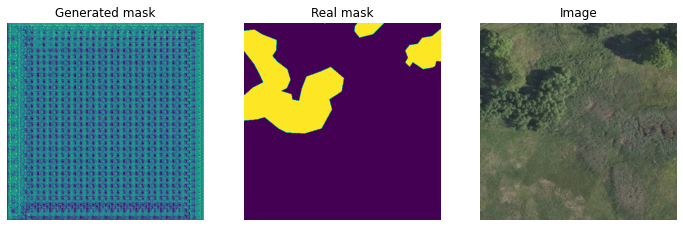

<Figure size 432x288 with 0 Axes>

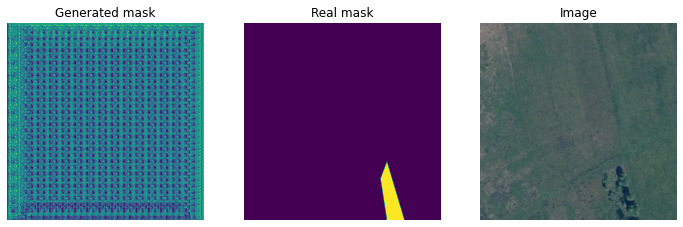

<Figure size 432x288 with 0 Axes>

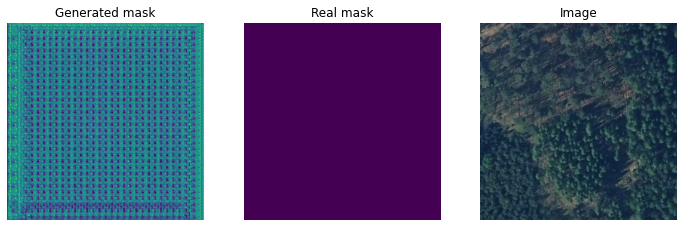

<Figure size 432x288 with 0 Axes>

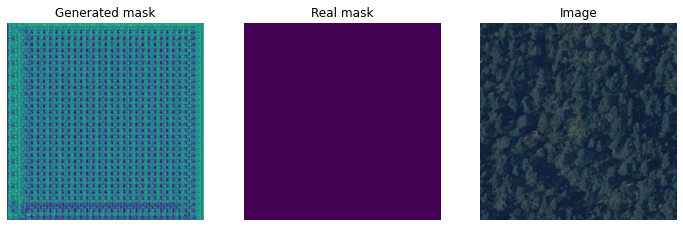

In [245]:
train(train_generator, EPOCHS)

In [ ]:
discriminator.save_weights('./results/final_gan/discriminator.h5')

In [ ]:
generator.save_weights('./results/final_gan/generator.h5')

In [ ]:
show_predictions(cmap=EACH_CLASS_CMAP, norm=CLASS_NORM)